
# CAPSTONE
## Battle of the Neighborhoods
### Restaurants of Kharkiv

##### Aleksandr V.
-------------------------------------------------------------------------------------------------------
### Introduction

This final project explores the best locations for restaurants throughout the city of Kharkiv, Ukraine (https://en.wikipedia.org/wiki/Kharkiv). Kharkiv is the second-largest city in in Ukraine, with more than 2 million people living within city limits. This report explores neighborhoods of Kharkiv and tries to answer which neighborhoods and boroughs of Kharkiv have the most as well as the best restaurants. Additionally, I will attempt to answer the questions “Where should I open an Restaurant?” and “Where should I stay If I want great food?”


### Data

In order to answer the above questions, data on Kharkiv neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

Kharkiv data containing the boroughs will be obtained from the data source: "https://www.city.kharkov.ua/ru/gorodskaya-vlast/ispolnitelnyie-organyi/rajonnyie-administraczii.html", latitudes and longitudes of borough's administrations will be obtained by geocoding.


All data related to locations and quality of restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

### Methodology

• Data will be collected from internet and cleaned and processed into a dataframe.
• FourSquare be used to locate all venues and then filtered by restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.
• Data will be sorted based on rankings
• Finally, the data be will be visually assessed using graphing from various Python libraries.

### Problem Statement

    What is / are the best location(s) for restaurant in Kharkiv?
    In what Neighborhood and/or borough should I open an  restaurant to have the best chance of being successful?
    Where would I go in Kharkiv have the best food?



In [1]:
!conda install -c conda-forge geocoder --yes

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
!conda install -c conda-forge folium --yes 

Solving environment: ...working... done

# All requested packages already installed.



In [3]:
import pandas as pd
import numpy as np
import geocoder # import geocoder


In [4]:
import pandas
from bs4 import BeautifulSoup
import requests 

resp = requests.get('https://www.city.kharkov.ua/ru/gorodskaya-vlast/ispolnitelnyie-organyi/rajonnyie-administraczii.html')
soup = BeautifulSoup(resp.text, 'lxml')

nbhs= soup.findAll("div", {"class": "hidden_box"})

df_ = pd.DataFrame(columns=['Neighbourhood','Address','Latitude','Longitude'])

for t in nbhs:
    tsoup= BeautifulSoup(t.get_text(), 'lxml')
    txt= tsoup.p.text
    Neighbourhood= txt.split('\n')[0].strip()
    Address= txt.split('\n')[1].split(':')[1].strip()

    _coords = None
    # loop until you get the coordinates
    while(_coords is None):
        gcd= geocoder.geocodefarm(Address)
        _coords = gcd.latlng
    
    latitude= _coords[0]
    longitude= _coords[1]

    s={'Neighbourhood':Neighbourhood, 'Address':Address,'Latitude':latitude,'Longitude':longitude }
  
    #print(s)
    df_= df_.append(s,ignore_index=True)

df_.head()

,Neighbourhood,Address,Latitude,Longitude
0,Шевченковский район,"61166 г. Харьков, пр. Науки, 17 А",50.018282,36.223593
1,Киевский район,"61002, г. Харьков, ул. Чернышевская, 55",50.004819,36.239594
2,Слободской район,"61001 г. Харьков, ул. Плехановская, 42",49.980819,36.256594
3,Холодногорский район,"61052 г. Харьков, ул.Благовещенская, 34",49.989819,36.213593
4,Московский район,"61001 г. Харьков, ул. Юрьевская, 13",49.992819,36.254594


In [5]:
import folium # map rendering library

_latitude = df_.iloc[0]['Latitude']
_longitude = df_.iloc[0]['Longitude']


In [6]:
# create map of Manhattan using latitude and longitude values
map_Kharkov = folium.Map(location=[_latitude, _longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_['Latitude'], df_['Longitude'], df_['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Kharkov)  

folium.TileLayer('openstreetmap').add_to(map_Kharkov)    
    
map_Kharkov

In [7]:
CLIENT_ID = 'VFPQIHROZ2NZV5ODTHCDDPEEWTWD1RFT1ER4B3LACT5JIIP3' # your Foursquare ID
CLIENT_SECRET = 'KXUFQAIO4O2BN4W5I2A4CJISDTWNMFW2PSXP5BZ43MSTNXUD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VFPQIHROZ2NZV5ODTHCDDPEEWTWD1RFT1ER4B3LACT5JIIP3
CLIENT_SECRET:KXUFQAIO4O2BN4W5I2A4CJISDTWNMFW2PSXP5BZ43MSTNXUD


In [39]:
def get_nearby_venues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue Id',            
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
_venues = get_nearby_venues(names=df_['Neighbourhood'],
    latitudes=df_['Latitude'],
    longitudes=df_['Longitude'],
    radius=500                        
    )


Шевченковский район
Киевский район
Слободской район
Холодногорский район
Московский район
Новобаварский район
Индустриальный район
Немышлянский район
Основянский район


In [41]:
_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,,
Индустриальный район,13,13,13,13,13,13,13
Киевский район,73,73,73,73,73,73,73
Московский район,10,10,10,10,10,10,10
Немышлянский район,18,18,18,18,18,18,18
Новобаварский район,38,38,38,38,38,38,38
Основянский район,17,17,17,17,17,17,17
Слободской район,28,28,28,28,28,28,28
Холодногорский район,35,35,35,35,35,35,35
Шевченковский район,59,59,59,59,59,59,59


In [11]:
# one hot encoding
_onehot = pd.get_dummies(_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
_onehot['Neighbourhood'] = _venues['Neighbourhood'] 

# move Neighbourhood column to the first column
fixed_columns = [_onehot.columns[-1]] + list(_onehot.columns[:-1])
_onehot = _onehot[fixed_columns]

_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Шевченковский район,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Шевченковский район,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Шевченковский район,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Шевченковский район,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Шевченковский район,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
_onehot.shape

(659, 158)

In [13]:
_grouped = _onehot.groupby('Neighbourhood').mean().reset_index()
_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Индустриальный район,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,Киевский район,0.01,0.000000,0.000000,0.000000,0.020000,0.000000,0.01,0.02,0.01,...,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.01,0.020000,0.020000,0.020000
2,Московский район,0.00,0.000000,0.021277,0.000000,0.085106,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.00,0.021277,0.000000,0.000000
3,Немышлянский район,0.00,0.016667,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
4,Новобаварский район,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.01,0.000000,0.020000,0.040000
5,Основянский район,0.00,0.000000,0.000000,0.011905,0.011905,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.011905,0.011905,0.00,0.011905,0.000000,0.011905
6,Слободской район,0.00,0.000000,0.000000,0.000000,0.010753,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.010753,0.000000,0.00,0.010753,0.000000,0.010753
7,Холодногорский район,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.029412,0.014706,0.000000,0.000000,0.000000,0.029412,0.00,0.000000,0.014706,0.014706
8,Шевченковский район,0.00,0.000000,0.000000,0.000000,0.000000,0.010989,0.00,0.00,0.00,...,0.000000,0.000000,0.010989,0.010989,0.000000,0.000000,0.00,0.010989,0.000000,0.010989


In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = _grouped['Neighbourhood']

for ind in np.arange(_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Индустриальный район,Park,Bakery,Spa,Coffee Shop,Plaza,Cosmetics Shop,Café,Eastern European Restaurant,Burger Joint,Big Box Store
1,Киевский район,Coffee Shop,Theater,Gastropub,Dessert Shop,Boutique,Café,Yoga Studio,Caucasian Restaurant,Restaurant,Women's Store
2,Московский район,Coffee Shop,Arcade,Hotel,Plaza,Gym / Fitness Center,Pet Store,Café,Shopping Mall,Italian Restaurant,Karaoke Bar
3,Немышлянский район,Coffee Shop,Pizza Place,Bakery,Grocery Store,Lounge,Café,Hotel,Fast Food Restaurant,Park,Gym
4,Новобаварский район,Restaurant,Park,Coffee Shop,Yoga Studio,Bakery,Hookah Bar,Flower Shop,Caucasian Restaurant,Theater,Candy Store


In [16]:
# import k-means from clustering stage
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [17]:
#data=pd.DataFrame(_grouped)

_grouped_clustering = _grouped.drop('Neighbourhood', 1)


data=_grouped_clustering
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

In [18]:
Sum_of_squared_distances = []
K = range(1,9)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

In [19]:
import matplotlib.pyplot as plt

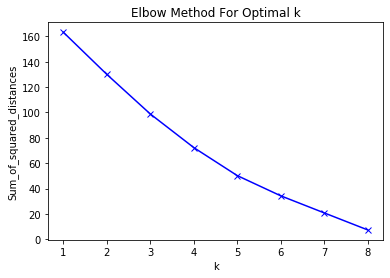

In [20]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [21]:
#Run *k*-means to cluster the neighborhood into clusters.
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 5, 2, 3, 1, 1, 3, 1])

In [22]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [23]:
neighborhoods_venues_sorted

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Индустриальный район,Park,Bakery,Spa,Coffee Shop,Plaza,Cosmetics Shop,Café,Eastern European Restaurant,Burger Joint,Big Box Store
1,4,Киевский район,Coffee Shop,Theater,Gastropub,Dessert Shop,Boutique,Café,Yoga Studio,Caucasian Restaurant,Restaurant,Women's Store
2,5,Московский район,Coffee Shop,Arcade,Hotel,Plaza,Gym / Fitness Center,Pet Store,Café,Shopping Mall,Italian Restaurant,Karaoke Bar
3,2,Немышлянский район,Coffee Shop,Pizza Place,Bakery,Grocery Store,Lounge,Café,Hotel,Fast Food Restaurant,Park,Gym
4,3,Новобаварский район,Restaurant,Park,Coffee Shop,Yoga Studio,Bakery,Hookah Bar,Flower Shop,Caucasian Restaurant,Theater,Candy Store
5,1,Основянский район,Hotel,Coffee Shop,Gym / Fitness Center,Café,Dance Studio,Restaurant,Plaza,Soccer Field,Park,Bakery
6,1,Слободской район,Gym / Fitness Center,Café,Dance Studio,Coffee Shop,Bakery,Hotel,Sporting Goods Shop,Italian Restaurant,Pub,Bookstore
7,3,Холодногорский район,Bakery,Restaurant,Platform,Fast Food Restaurant,Park,Coffee Shop,Electronics Store,Hookah Bar,Waterfront,Train Station
8,1,Шевченковский район,Coffee Shop,Bakery,Gym / Fitness Center,Café,Hotel,Italian Restaurant,Restaurant,Gym,Nightclub,Cocktail Bar


In [24]:
neighborhoods_venues_indexed=neighborhoods_venues_sorted.set_index('Neighbourhood')

In [25]:
_merged=df_.reset_index(drop=True)

# merge to add latitude/longitude for each neighborhood
_merged = _merged.join(neighborhoods_venues_indexed, on='Neighbourhood', how='inner')

In [26]:
_merged.head() # check the last columns!

,Neighbourhood,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Шевченковский район,"61166 г. Харьков, пр. Науки, 17 А",50.018282,36.223593,1,Coffee Shop,Bakery,Gym / Fitness Center,Café,Hotel,Italian Restaurant,Restaurant,Gym,Nightclub,Cocktail Bar
1,Киевский район,"61002, г. Харьков, ул. Чернышевская, 55",50.004819,36.239594,4,Coffee Shop,Theater,Gastropub,Dessert Shop,Boutique,Café,Yoga Studio,Caucasian Restaurant,Restaurant,Women's Store
2,Слободской район,"61001 г. Харьков, ул. Плехановская, 42",49.980819,36.256594,1,Gym / Fitness Center,Café,Dance Studio,Coffee Shop,Bakery,Hotel,Sporting Goods Shop,Italian Restaurant,Pub,Bookstore
3,Холодногорский район,"61052 г. Харьков, ул.Благовещенская, 34",49.989819,36.213593,3,Bakery,Restaurant,Platform,Fast Food Restaurant,Park,Coffee Shop,Electronics Store,Hookah Bar,Waterfront,Train Station
4,Московский район,"61001 г. Харьков, ул. Юрьевская, 13",49.992819,36.254594,5,Coffee Shop,Arcade,Hotel,Plaza,Gym / Fitness Center,Pet Store,Café,Shopping Mall,Italian Restaurant,Karaoke Bar


In [27]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[_latitude, _longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


In [28]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(_merged['Latitude'], _merged['Longitude'], _merged['Neighbourhood'], _merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [56]:
_venues


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Шевченковский район,50.018282,36.223593,5630fedf498e744309ae78f8,Trattoria Sicilia,50.018380,36.224399,Italian Restaurant
1,Шевченковский район,50.018282,36.223593,4f6c72ade4b03b3f3854c57f,Дом Кофе,50.017474,36.225610,Miscellaneous Shop
2,Шевченковский район,50.018282,36.223593,589d94b201f0771ff246db15,Мастерская кофе,50.017108,36.225666,Coffee Shop
3,Шевченковский район,50.018282,36.223593,4fbcb6a2e4b0090538c050f4,Дом Кофе,50.019266,36.225155,Miscellaneous Shop
4,Шевченковский район,50.018282,36.223593,522d87ae2fc67a76e312b596,Argentina Grill,50.017469,36.226025,Argentinian Restaurant
...,...,...,...,...,...,...,...,...
286,Основянский район,49.988819,36.252594,4c3460cc16adc928d7fdc49c,Площа Героїв Небесної Сотні,49.989127,36.247100,Plaza
287,Основянский район,49.988819,36.252594,504d8c94e4b03e4ada25143f,BlaserCafe,49.986299,36.256724,Coffee Shop
288,Основянский район,49.988819,36.252594,56fbb203cd10a3afdccdc637,Домашні Страви,49.986569,36.256704,Café
289,Основянский район,49.988819,36.252594,4d0488bd2f96f04dd2891e54,Вікторія / Victoria Hotel,49.991444,36.252027,Hotel


In [44]:
_resturants=_venues[_venues['Venue Category'].str.contains('Restaurant', na=False)]
_resturants.drop_duplicates(subset =['Venue Id'], keep = False, inplace = True) 

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
_resturants.shape

(34, 8)

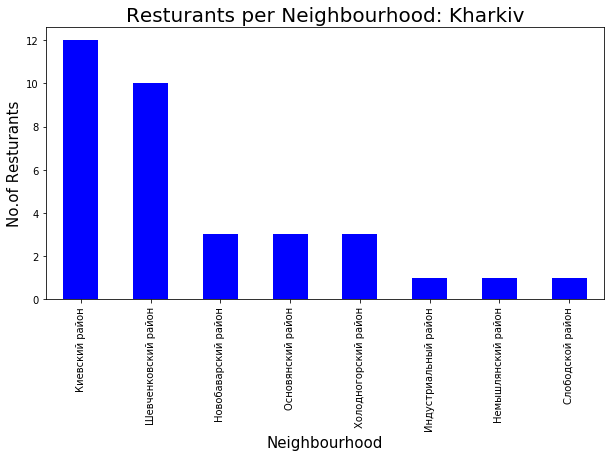

In [139]:
NOofNeigh = 10 # top number for graphing all the same past 6
_resturants.groupby('Neighbourhood')['Venue Id'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color = "blue")
plt.title('Resturants per Neighbourhood: Kharkiv', fontsize = 20)
plt.xlabel('Neighbourhood', fontsize = 15)
plt.ylabel('No.of Resturants', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

In [121]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    #print(results)
    venue_details=[]
    
    try:
        venue_data=results['response']['venue']
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except Exception as e:
        print(e)
        print(results)
        pass
    
    df = pd.DataFrame(venue_details,columns=['Venue Id','Venue Name','Likes','Rating','Tips'])
    return df

In [122]:
_resturants_stats=pd.DataFrame(columns=['Neighbourhood', 'Venue Id','Venue Name','Venue Latitude','Venue Longitude','Likes','Rating','Tips'])

count=1
for row in _resturants.values.tolist():
    NbName,NbLat,NbLng,VenueId,VenueName,VenueLat,VenueLng,VenueCat=row
    
    try:
        venue_details=get_venue_details(VenueId)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for venue "',VenueName,'" with Id = ',VenueId)
        # we will assign 0 value for these resturants as details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
        
    print('(',count,'/',len(_resturants),')','processed', ' (',VenueName,')')
    
    _resturants_stats = _resturants_stats.append({
        'Neighbourhood': NbName, 
        'Venue Id': id,
        'Venue Name': name,
        'Venue Latitude': VenueLat,
        'Venue Longitude': VenueLng,
        'Likes': likes,
        'Rating': rating,
        'Tips': tips
       }, ignore_index=True)
    
    count+=1
  
_resturants_stats.head()

( 1 / 34 ) processed  ( Trattoria Sicilia )
( 2 / 34 ) processed  ( Argentina Grill )
( 3 / 34 ) processed  ( Escobar )
( 4 / 34 ) processed  ( De Gusto )
( 5 / 34 ) processed  ( Green Food Cafe )
( 6 / 34 ) processed  ( Япошка )
( 7 / 34 ) processed  ( La Strada )
( 8 / 34 ) processed  ( Taboo Lounge 24 )
( 9 / 34 ) processed  ( True Price Seafood )
( 10 / 34 ) processed  ( M-Royal )
( 11 / 34 ) processed  ( Чехов )
( 12 / 34 ) processed  ( Мне Бы Рыбы )
( 13 / 34 ) processed  ( Шотi / Shoti )
( 14 / 34 ) processed  ( GOA )
( 15 / 34 ) processed  ( Paris / Париж )
( 16 / 34 ) processed  ( Forchino )
( 17 / 34 ) processed  ( AristOcrate )
( 18 / 34 ) processed  ( GEORGIA | Джорджия Харьков )
( 19 / 34 ) processed  ( Япошка )
( 20 / 34 ) processed  ( Jord )
( 21 / 34 ) processed  ( Horoshee Mesto. Kitchen&Bar )
( 22 / 34 ) processed  ( LUMBER Gastro Bar )
( 23 / 34 ) processed  ( Ресторан Металлист )
( 24 / 34 ) processed  ( Vincent Restaurant&Louge )
( 25 / 34 ) processed  ( Кумэ )
( 2

,Neighbourhood,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Likes,Rating,Tips
0,Шевченковский район,5630fedf498e744309ae78f8,Trattoria Sicilia,50.018380,36.224399,460,9.0,129
1,Шевченковский район,522d87ae2fc67a76e312b596,Argentina Grill,50.017469,36.226025,1078,8.3,292
2,Шевченковский район,58138deb38faf8ac17ca5954,Escobar,50.018905,36.224782,103,7.9,56
3,Шевченковский район,5352493d498e830ce0f2def1,De Gusto,50.015495,36.221412,787,8.3,294
4,Шевченковский район,59e345c7364d975fc384efb6,Green Food Cafe,50.014957,36.220795,39,8.1,19


In [138]:
kh_map_restorants = folium.Map(location=[_latitude, _longitude], zoom_start=13)

# add markers on the map
for vname, lat, lng, likes, rating, tips in _resturants_stats[['Venue Name','Venue Latitude','Venue Longitude','Likes','Rating','Tips']].values:
    label='' + str(vname) +' ('+ str(rating)+'/'+str(likes)+'/'+str(tips)+')'   
    folium.Marker([lat, lng], popup=label).add_to(kh_map_restorants)        

kh_map_restorants

In [71]:
_resturants_stats.info()
_resturants_stats['Likes']=_resturants_stats['Likes'].astype('float64')
_resturants_stats['Tips']=_resturants_stats['Tips'].astype('float64')
#_resturants_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
Neighborhood    34 non-null object
Venue Id        34 non-null object
Venue Name      34 non-null object
Likes           34 non-null object
Rating          34 non-null float64
Tips            34 non-null object
dtypes: float64(1), object(5)
memory usage: 1.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
Neighborhood    34 non-null object
Venue Id        34 non-null object
Venue Name      34 non-null object
Likes           34 non-null float64
Rating          34 non-null float64
Tips            34 non-null float64
dtypes: float64(3), object(3)
memory usage: 1.7+ KB


In [72]:
_resturants_stats.describe()

,Likes,Rating,Tips
count,34.000000,34.000000,34.000000
mean,250.794118,7.058824,101.205882
std,401.748208,1.582311,143.423463
min,0.000000,0.000000,0.000000
25%,16.500000,6.225000,8.750000
50%,65.000000,7.550000,41.500000
75%,359.750000,8.000000,179.000000
max,1932.000000,9.000000,697.000000


Resturant with maximum Likes:

In [73]:
_resturants_stats.iloc[_resturants_stats['Likes'].idxmax()]

Neighborhood              Киевский район
Venue Id        4c32153aa0ced13a2188146e
Venue Name                 Paris / Париж
Likes                               1932
Rating                               8.7
Tips                                 697
Name: 14, dtype: object

Resturant with maximum Ratings:

In [74]:
_resturants_stats.iloc[_resturants_stats['Rating'].idxmax()]

Neighborhood         Шевченковский район
Venue Id        5630fedf498e744309ae78f8
Venue Name             Trattoria Sicilia
Likes                                460
Rating                                 9
Tips                                 129
Name: 0, dtype: object

Resturant with maximum Tips:

In [75]:
_resturants_stats.iloc[_resturants_stats['Tips'].idxmax()]

Neighborhood              Киевский район
Venue Id        4c32153aa0ced13a2188146e
Venue Name                 Paris / Париж
Likes                               1932
Rating                               8.7
Tips                                 697
Name: 14, dtype: object

In [100]:
_resturants_stats.rename(columns={'Neighborhood': 'Neighbourhood'}, inplace=True)


In [101]:
_resturants_stats.dtypes

Neighbourhood     object
Venue Id          object
Venue Name        object
Likes            float64
Rating           float64
Tips             float64
dtype: object

In [102]:

_neighborhood_stats=_resturants_stats.groupby('Neighbourhood',as_index=False).mean()[['Neighbourhood','Rating']]
_neighborhood_stats.columns=['Neighbourhood','Average Rating']
_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighbourhood,Average Rating
2,Немышлянский район,8.000000
1,Киевский район,7.775000
7,Шевченковский район,7.180000
4,Основянский район,6.800000
3,Новобаварский район,6.766667
6,Холодногорский район,6.666667
5,Слободской район,6.200000
0,Индустриальный район,0.000000


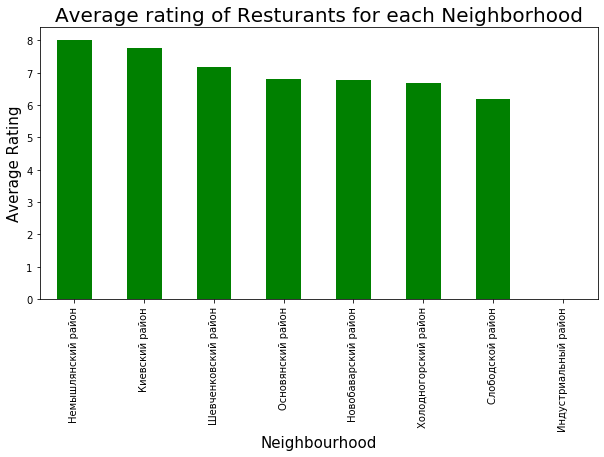

In [105]:
_resturants_stats.groupby('Neighbourhood').mean()['Rating'].nlargest(NOofNeigh).plot.bar(figsize=(10,5), color='green')
plt.title('Average rating of Resturants for each Neighborhood', fontsize=20)
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

We will visually map the neighborhoods with an average rating

In [111]:
kh_neighborhood_stats=pd.merge(_neighborhood_stats,df_, on='Neighbourhood')
kh_neighborhood_stats=kh_neighborhood_stats[['Neighbourhood','Latitude','Longitude','Average Rating']]
kh_neighborhood_stats['Label']=kh_neighborhood_stats['Neighbourhood']+' ('+round(kh_neighborhood_stats['Average Rating'],2).map(str)+')'
kh_neighborhood_stats

,Neighbourhood,Latitude,Longitude,Average Rating,Label
0,Индустриальный район,49.944818,36.372596,0.000000,Индустриальный район (0.0)
1,Киевский район,50.004819,36.239594,7.775000,Киевский район (7.78)
2,Немышлянский район,49.958819,36.318595,8.000000,Немышлянский район (8.0)
3,Новобаварский район,49.987782,36.222159,6.766667,Новобаварский район (6.77)
4,Основянский район,49.988819,36.252594,6.800000,Основянский район (6.8)
5,Слободской район,49.980819,36.256594,6.200000,Слободской район (6.2)
6,Холодногорский район,49.989819,36.213593,6.666667,Холодногорский район (6.67)
7,Шевченковский район,50.018282,36.223593,7.180000,Шевченковский район (7.18)


In [114]:
kh_map = folium.Map(location=[_latitude, _longitude], zoom_start=11)
kh_map_rest = folium.map.FeatureGroup()
for lat, lng, in kh_neighborhood_stats[['Latitude','Longitude']].values:
    kh_map_rest.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
for lat, lng, label in kh_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(kh_map)        

# add restorants to map
kh_map.add_child(kh_map_rest)

kh_map


# Results / Conclusion

Nemyshlianskyi and Shevchenkivskyi neibourhoods have the best rated restaurants on average. Kievskyi and Shevchenkivskyi neibourhoods have the largest amount of restaurants per borough. Based on this information, I would state that Slobidskyi, Osnovianskyi  and Novobavarskyi neibourhoods are the best locations for new restaurants. 
As a final note, all of the above analysis is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.
